# Milestone 1 Phase 2

**Name: Prabaningrum Hendraswari Buitjahjono**

**Batch: 001-HCK**

In [33]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import tensorflow as tf
import pickle
import warnings
warnings.filterwarnings('ignore')

# For Balancing
from imblearn.over_sampling import SMOTENC

# For Feature Encoding
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,LabelEncoder

# For Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# For Model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# Split between Train-Set and Test-Set
from sklearn.model_selection import train_test_split

# To Evaluate and Improve Models
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix, roc_auc_score, roc_curve,precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

np.random.seed(101)
tf.random.set_seed(101)

In [34]:
#Loading dataset

df = pd.read_csv('Telco-Customer-Churn.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [35]:
df.tail(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## EDA

In [36]:
#for backup
df1 = df.copy()

In [37]:
#checking missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Initially, there were 21 columns at first including the target column. From the raw data, it's known that we do not need customerID column since we already have indexing and thus we are going to drop it later on.

In [38]:
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

From that exploration, it can be known that there are 11 blank data in column TotalCharges that can be interpreted as missing value, therefore we are also going to drop those rows in data cleaning.

In [39]:
#checking for duplicates
df.duplicated().sum()

0

There seems to be no duplicate data detected.

<AxesSubplot:xlabel='Churn', ylabel='count'>

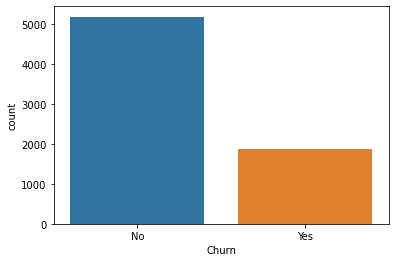

In [40]:
sns.countplot(df['Churn'])

In [41]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

From the data, it is known that the amount of people in each category in churn column is pretty imbalanced with 5174 people having "No" as their group, and 1869 people having "Yes" as their group. This might be a problem later on in the data so we are going to solve it with oversampling through SMOTENC in preprocessing.

In [42]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


From the "numerical" column description, there seems to be no anomaly. However, it can also be known that SeniorCitizen is actually a categorical data that has been encoded.

**Data Cleaning**

In [43]:
#Dropping CustomerID
df1.drop(['customerID'], axis=1, inplace=True)


In [44]:
#Checking the data
df1.shape

(7043, 20)

In [45]:
#Dropping missing values
df_new = df1[df1['TotalCharges'] != ' ']
df_new.shape


(7032, 20)

In [46]:
#Changing data type of TotalCharges since the missing value has been dropped
df_new['TotalCharges'] = df_new['TotalCharges'].astype(float)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


**correlation or hypothesis testing**

interval columns not set, guessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


<AxesSubplot:>

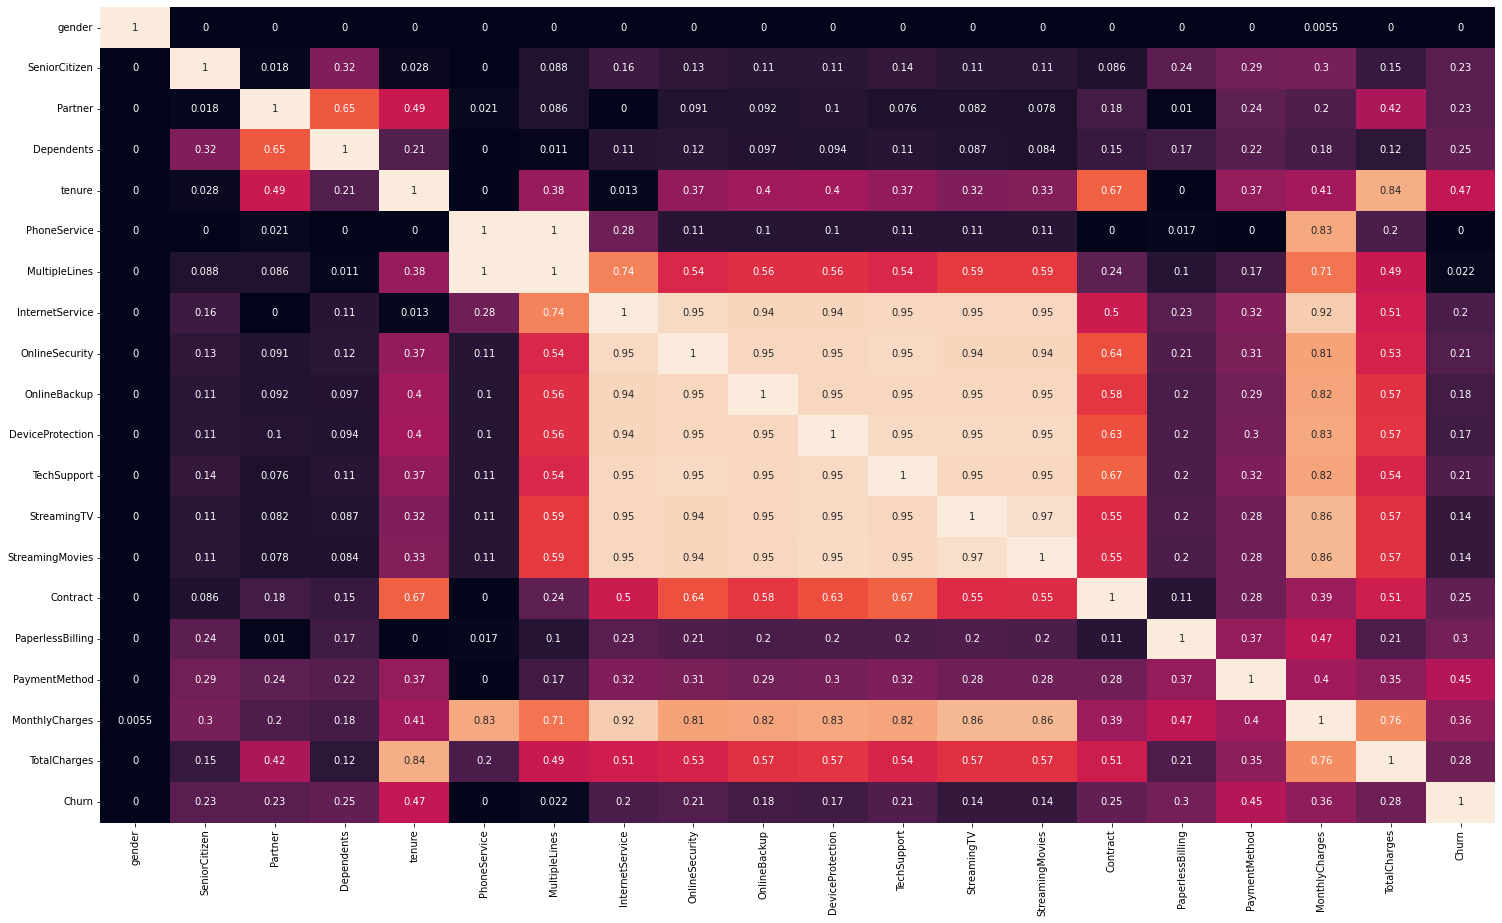

In [47]:
# Feature Correlation
# Setting figure size
fig = plt.figure(figsize = (25, 15))

# Heatmap plotting
sns.heatmap(df_new.phik_matrix(),
            vmin = 0,
            vmax = 1,
            annot = True,
            cbar = False
)

From the heatmap of phik score, it is known that there are numerous columns that has low correlation. In this case, I'm going to use the columns that has a correlation above 0.2 and thus, I'm dropping gender, PhoneService, MultipleLines, OnlineBackup, DeviceProtection, StreamingTV, and StreamingMovies.

## Feature Selection

In [48]:
df_clean = df_new.drop(['gender', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'], axis=1)
df_clean.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,DSL,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,DSL,Yes,No,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,DSL,Yes,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,DSL,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,Fiber optic,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [49]:
#Changing the data type of SeniorCitizen since it's actually a categorical data
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].astype(str)

In [50]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7032 non-null   object 
 1   Partner           7032 non-null   object 
 2   Dependents        7032 non-null   object 
 3   tenure            7032 non-null   int64  
 4   InternetService   7032 non-null   object 
 5   OnlineSecurity    7032 non-null   object 
 6   TechSupport       7032 non-null   object 
 7   Contract          7032 non-null   object 
 8   PaperlessBilling  7032 non-null   object 
 9   PaymentMethod     7032 non-null   object 
 10  MonthlyCharges    7032 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 769.1+ KB


## Feature Engineering

**Data Preprocessing**

In [51]:
#Outlier checking
#defining function
def diagnostic_plots(df_clean, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean[variable])
    plt.title('Boxplot')

    plt.show()

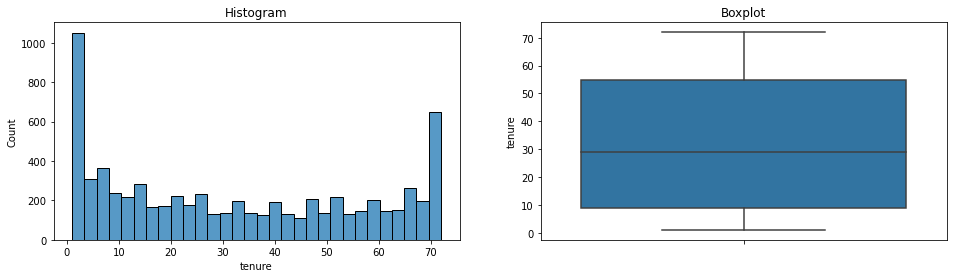

In [52]:
diagnostic_plots(df_clean, 'tenure')

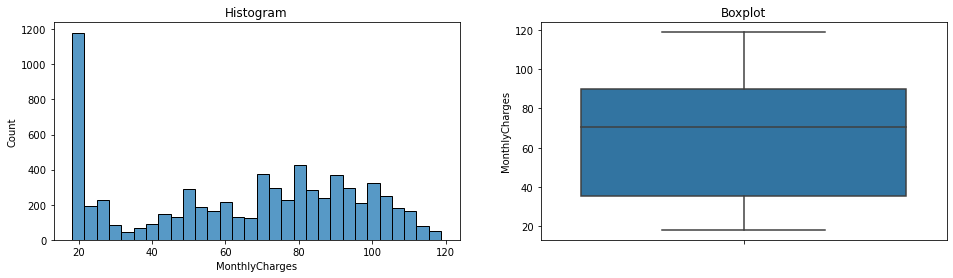

In [53]:
diagnostic_plots(df_clean, 'MonthlyCharges')

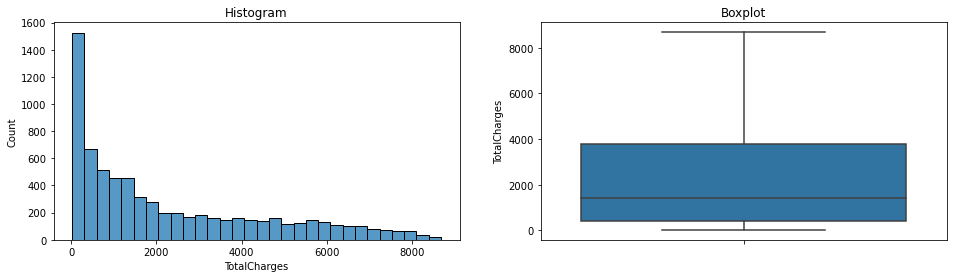

In [54]:
diagnostic_plots(df_clean, 'TotalCharges')

In [55]:
df_clean.skew()

SeniorCitizen     1.831103
tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64

In [56]:
df_clean_num = df_clean[['tenure', 'MonthlyCharges', 'TotalCharges']]
df_clean_num.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


From the checking, it can be inferred that there is no outlier in the numerical datas though when checking the skew value, somehow SeniorCitizen is still included in it though we are not going to use it as a numerical data. From the skew value, there is one column that has a moderate skew. This will affect the kind of scaling that we are going to use.

**Data Splitting**

In [57]:
#Data for model inference
df_inf = df_clean.sample(10, random_state=101)
df_inf

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4253,0,Yes,Yes,22,Fiber optic,No,No,Month-to-month,Yes,Electronic check,88.75,1885.15,No
2914,0,No,No,32,DSL,No,No,One year,Yes,Bank transfer (automatic),64.85,2010.95,No
1569,0,Yes,Yes,15,DSL,No,No,Month-to-month,No,Electronic check,46.30,639.45,No
5227,0,No,No,7,Fiber optic,No,No,Month-to-month,No,Electronic check,96.20,639.70,No
4427,0,No,No,49,Fiber optic,No,Yes,Two year,No,Credit card (automatic),100.65,4917.75,No
5879,0,Yes,No,33,DSL,Yes,Yes,Two year,Yes,Mailed check,61.05,2018.40,No
155,0,Yes,Yes,14,Fiber optic,No,No,Month-to-month,Yes,Bank transfer (automatic),80.90,1152.80,No
109,0,Yes,Yes,72,No,No internet service,No internet service,Two year,No,Credit card (automatic),19.40,1363.25,No
5023,0,No,No,1,Fiber optic,No,No,Month-to-month,Yes,Electronic check,70.30,70.30,Yes
5257,1,No,No,37,Fiber optic,No,No,Month-to-month,Yes,Electronic check,101.10,3744.05,Yes


In [58]:
#Remove inf data from dataframe
df_train_test = df_clean.drop(df_inf.index)
df_train_test

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,DSL,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,DSL,Yes,No,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,DSL,Yes,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,DSL,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,Fiber optic,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,24,DSL,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,0,Yes,Yes,72,Fiber optic,No,No,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,0,Yes,Yes,11,DSL,Yes,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,1,Yes,No,4,Fiber optic,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [59]:
#Reset Index
df_train_test.reset_index(drop=True, inplace=True) 
df_inf.reset_index(drop=True, inplace=True)

In [60]:
#Splitting feature and target
x = df_train_test.drop(['Churn'], axis=1) 
y = df_train_test['Churn']

In [61]:
# Splitting training data and test data
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=101)

print('Train Size : ', x_train.shape)
print('Validation Size: ', x_val.shape)
print('Test Size  : ', x_test.shape)

Train Size :  (4493, 12)
Validation Size:  (1124, 12)
Test Size  :  (1405, 12)


In [62]:
#Resetting index
x_train_copy = x_train.copy()
x_val_copy = x_val.copy()
x_test_copy = x_test.copy()
x_train = x_train.reset_index()
x_val = x_val.reset_index()
x_test = x_test.reset_index()

**encoding**

In [63]:
#Encoding
#Determining the values to encode in order
partner_categories = ['No', 'Yes']
dependents_categories = ['No', 'Yes']
internetservice_categories = ['Fiber optic', 'DSL', 'No']
onlinesecurity_categories = ['No', 'Yes', 'No internet service']
techsupport_categories = ['No', 'Yes', 'No internet service']
contract_categories = ['Month-to-month', 'Two year', 'One year']
paperlessbilling_categories = ['No', 'Yes']
paymentmethod_categories = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

In [65]:
#Encoding features with ordinal encoder
ord_enc = OrdinalEncoder(categories = [partner_categories,dependents_categories,internetservice_categories, onlinesecurity_categories, techsupport_categories, contract_categories, paperlessbilling_categories, paymentmethod_categories])

x_train1 = ord_enc.fit_transform(x_train[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']])
x_train_fin = pd.DataFrame(x_train1, columns=['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod'])
x_val1 = ord_enc.transform(x_val[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']])
x_val_fin = pd.DataFrame(x_val1, columns=['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod'])
x_test1 = ord_enc.transform(x_test[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']])
x_test_fin = pd.DataFrame(x_test1, columns=['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod'])
x_train_fin

,Partner,Dependents,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
4488,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0
4489,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4490,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
4491,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0


In [66]:
#Encoding target with LabelEncoder
lab_enc = LabelEncoder()

y_train1 = lab_enc.fit_transform(y_train)
y_train_fin = pd.DataFrame(y_train1, columns=['Churn'])
y_val1 = lab_enc.transform(y_val)
y_val_fin = pd.DataFrame(y_val1, columns=['Churn'])
y_test1 = lab_enc.transform(y_test)
y_test_fin = pd.DataFrame(y_test1, columns=['Churn'])

**scaling**

In [67]:
#Defining numerical columns in each data
x_train_num = x_train[['tenure', 'MonthlyCharges', 'TotalCharges']]
x_val_num = x_val[['tenure', 'MonthlyCharges', 'TotalCharges']]
x_test_num = x_test[['tenure', 'MonthlyCharges', 'TotalCharges']]
x_train_num.head()

,tenure,MonthlyCharges,TotalCharges
0,2,87.15,183.75
1,10,84.60,865.55
2,71,77.35,5550.10
3,71,58.25,4145.90
4,19,50.10,910.45


In [68]:
#Scaling
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train_num)
x_val_scaled = scaler.transform(x_val_num)
x_test_scaled = scaler.transform(x_test_num)

x_train_scl = pd.DataFrame(x_train_scaled, columns=[['tenure', 'MonthlyCharges', 'TotalCharges']])
x_val_scl = pd.DataFrame(x_val_scaled, columns=[['tenure', 'MonthlyCharges', 'TotalCharges']])
x_test_scl = pd.DataFrame(x_test_scaled, columns=[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [71]:
#Concat with non-encoded columns
x_train_final0 = np.concatenate([x_train_fin, x_train[['SeniorCitizen']]], axis=1)
x_val_final0 = np.concatenate([x_val_fin, x_val[['SeniorCitizen']]], axis=1)
x_test_final0 = np.concatenate([x_test_fin, x_test[['SeniorCitizen']]], axis=1)

x_train_cat = pd.DataFrame(x_train_final0, columns=[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod','SeniorCitizen']])
x_val_cat = pd.DataFrame(x_val_final0, columns=[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']])
x_test_cat = pd.DataFrame(x_test_final0, columns=[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']])

In [72]:
#Concat with categorical columns
x_train_final = np.concatenate([x_train_scl, x_train_cat], axis=1)
x_val_final = np.concatenate([x_val_scl, x_val_cat], axis=1)
x_test_final = np.concatenate([x_test_scl, x_test_cat], axis=1)

x_train_final_df = pd.DataFrame(x_train_final, columns=[['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']])
x_val_final_df = pd.DataFrame(x_val_final, columns=[['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']])
x_test_final_df = pd.DataFrame(x_test_final, columns=[['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']])

In [73]:
x_train_final_df

,tenure,MonthlyCharges,TotalCharges,Partner,Dependents,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen
0,0.014085,0.685572,0.019028,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0
1,0.126761,0.660199,0.097704,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1
2,0.985915,0.58806,0.638274,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,0
3,0.985915,0.39801,0.476237,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0
4,0.253521,0.316915,0.102885,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4488,0.394366,0.017413,0.066981,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,0
4489,0.366197,0.595025,0.244249,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4490,0.957746,0.866667,0.833354,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0
4491,0.521127,0.387065,0.257537,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,1


**Balancing train data**

In [74]:
sm = SMOTENC(random_state=101, categorical_features=[3,4,5,6,7,8,9,10])

x_train_bal, y_train_bal = sm.fit_resample(x_train_final_df, y_train_fin)

In [75]:
#Checking the amount of data entries after balancing
y_train_bal

,Churn
0,1
1,1
2,0
3,0
4,0
...,...
6613,1
6614,1
6615,1
6616,1


<AxesSubplot:xlabel='Churn', ylabel='count'>

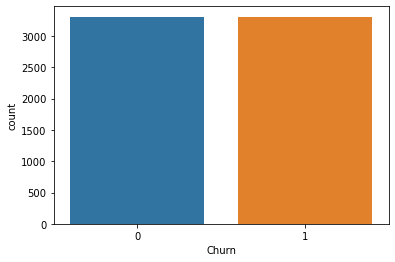

In [76]:
#checking the data after balancing
sns.countplot(y_train_bal['Churn'])

From the plot, it can be known that the data balancing is successfully done now that the ratio between both groups are 1:1

## Tensorflow Pipeline

In [78]:
# Creating tensorflow pipeline
train_pipe = tf.data.Dataset.from_tensor_slices((x_train_bal.astype("float32"), y_train_bal))
train_pipe = train_pipe.shuffle(buffer_size=100,seed=30).batch(30)
val_pipe = tf.data.Dataset.from_tensor_slices((x_val_final_df.astype("float32"), y_val_fin))
val_pipe = val_pipe.batch(30)
test_pipe = tf.data.Dataset.from_tensor_slices((x_test_final_df.astype("float32"), y_test_fin))
test_pipe = test_pipe.batch(30)

## Model Definition

In [80]:
# defining neuron amount
alp = 10
inp = x_train_bal.shape[1]
out = 1
hid = int(len(x_train_bal)/(alp*(inp+out)))
print(f'Jumlah Neuron pada Hidden Layer: {hid}')

Jumlah Neuron pada Hidden Layer: 50


**Sequential**

In [81]:
# Defining sequential model architecture
model_seq = tf.keras.models.Sequential()
model_seq.add(tf.keras.layers.Dense(inp, activation='relu', kernel_initializer='HeNormal', kernel_regularizer='l2', input_shape=(inp,))) # Input Layer
model_seq.add(tf.keras.layers.Dense(hid, activation='relu')) # Hidden Layer
model_seq.add(tf.keras.layers.Dense(out, activation='sigmoid')) # Output Layer
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 50)                650       
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


In [82]:
model_seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Functional**

In [83]:
# Defining functional model architecture

def get_uncompiled_model():
    input_func = tf.keras.Input(shape=(12,), name='input_func')
    input_func = tf.keras.layers.Dense(12, activation='relu', kernel_initializer='HeNormal', kernel_regularizer='l2')(input_func)
    hidden_func = tf.keras.layers.Dense(50, activation='relu', name='hidden_layer_func')(input_func)
    output_func = tf.keras.layers.Dense(1, activation='sigmoid', name='output_func')(hidden_func)
    model_func = tf.keras.Model(inputs=input_func, outputs=output_func)
    return model_func

# Define Training Configuration (Optimizer, Loss, Metrics)
def get_compiled_model():
    model_func = get_uncompiled_model()
    model_func.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'],)
    return model_func

## Model Training

**Sequential**

In [84]:
# Training Sequential model
history_seq = model_seq.fit(train_pipe, epochs=70, validation_data=(val_pipe))

print("\nEvaluate on test data")
result_seq = model_seq.evaluate(test_pipe)
print('Test - Loss     : ', result_seq[0])
print('Test - Accuracy : ', result_seq[1])
print('')

Epoch 1/70
221/221 [==============================] - 2s 4ms/step - loss: 0.5830 - accuracy: 0.8172 - val_loss: 3.0948 - val_accuracy: 0.2687
Epoch 2/70
221/221 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.7815 - val_loss: 1.5502 - val_accuracy: 0.2696
Epoch 3/70
221/221 [==============================] - 1s 3ms/step - loss: 0.5693 - accuracy: 0.7836 - val_loss: 1.4090 - val_accuracy: 0.2794
Epoch 4/70
221/221 [==============================] - 1s 3ms/step - loss: 0.5501 - accuracy: 0.7812 - val_loss: 1.2800 - val_accuracy: 0.3238
Epoch 5/70
221/221 [==============================] - 1s 3ms/step - loss: 0.5383 - accuracy: 0.7841 - val_loss: 1.1931 - val_accuracy: 0.3674
Epoch 6/70
221/221 [==============================] - 1s 3ms/step - loss: 0.5297 - accuracy: 0.7812 - val_loss: 1.1181 - val_accuracy: 0.4226
Epoch 7/70
221/221 [==============================] - 1s 3ms/step - loss: 0.5222 - accuracy: 0.7829 - val_loss: 1.0841 - val_accuracy: 0.4440
Epoch 

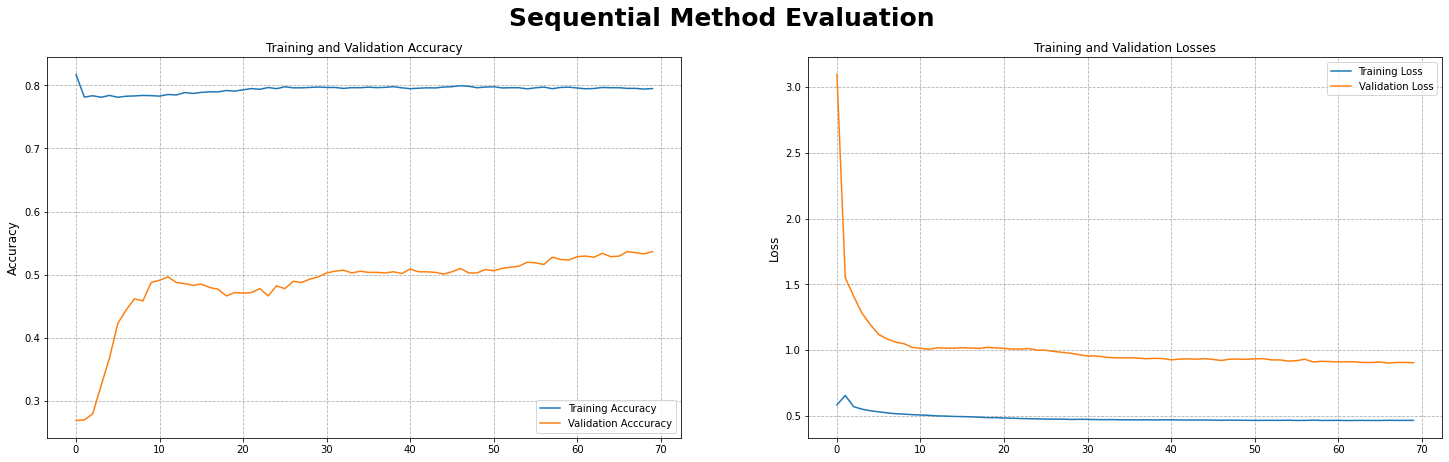

In [85]:
fig, ax = plt.subplots(1,2, figsize=(25,7))
fig.suptitle('Sequential Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_seq.history['accuracy'],label="Training Accuracy")
plt.plot(history_seq.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_seq.history['loss'], label="Training Loss")
plt.plot(history_seq.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

**Functional**

In [86]:
# Training Functional model
model_func = get_compiled_model()
history_func = model_func.fit(train_pipe, epochs=70, validation_data=(val_pipe))
print("\nEvaluate on test data")
result_func = model_func.evaluate(test_pipe)
print('Test - Loss     : ', result_func[0])
print('Test - Accuracy : ', result_func[1])
print('')

Epoch 1/70
221/221 [==============================] - 3s 7ms/step - loss: 0.4099 - accuracy: 0.8120 - val_loss: 2.4423 - val_accuracy: 0.2687
Epoch 2/70
221/221 [==============================] - 1s 4ms/step - loss: 0.5190 - accuracy: 0.7777 - val_loss: 1.3077 - val_accuracy: 0.3123
Epoch 3/70
221/221 [==============================] - 1s 3ms/step - loss: 0.4742 - accuracy: 0.7823 - val_loss: 1.1631 - val_accuracy: 0.3808
Epoch 4/70
221/221 [==============================] - 1s 3ms/step - loss: 0.4709 - accuracy: 0.7862 - val_loss: 1.0772 - val_accuracy: 0.4288
Epoch 5/70
221/221 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.7874 - val_loss: 1.0197 - val_accuracy: 0.4742
Epoch 6/70
221/221 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.7871 - val_loss: 0.9723 - val_accuracy: 0.4973
Epoch 7/70
221/221 [==============================] - 1s 3ms/step - loss: 0.4678 - accuracy: 0.7882 - val_loss: 0.9418 - val_accuracy: 0.5160
Epoch 

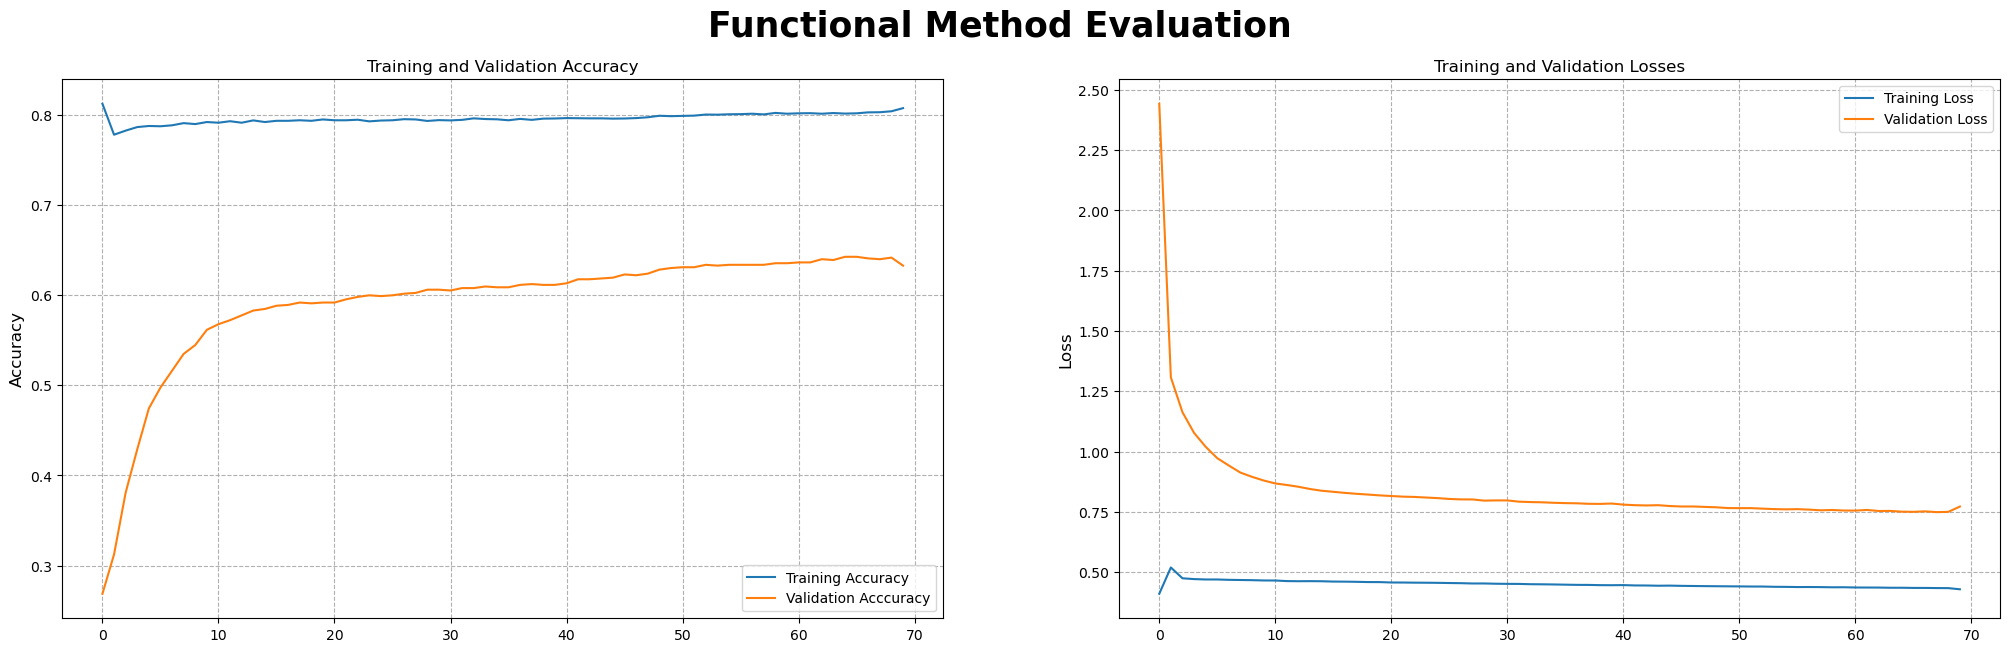

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (25, 7))
fig.suptitle('Functional Method Evaluation', fontsize = 25, weight = 'bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize = 12)
plt.plot(history_func.history['accuracy'], label = "Training Accuracy")
plt.plot(history_func.history['val_accuracy'], label = "Validation Acccuracy")
plt.ylabel("Accuracy", fontsize = 12)
plt.legend()
plt.grid(linestyle = '--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize = 12)
plt.plot(history_func.history['loss'], label = "Training Loss")
plt.plot(history_func.history['val_loss'], label = "Validation Loss")
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.grid(linestyle = '--')

plt.style.use('default')
plt.show()

From the plots, it is known that both methods are still performing terribly and overfitting the data even though the Functional Method seems to do better at 0.78 loss and 0.63 accuracy. Therefore, it needs some improvements by changing variables within the model.

## Model Improvements

**Sequential**

In [88]:
# Defining sequential model architecture
model_seq1 = tf.keras.models.Sequential()
model_seq1.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(inp,))) # Input Layer
model_seq1.add(tf.keras.layers.BatchNormalization())
model_seq1.add(tf.keras.layers.Dropout(0.4))
model_seq1.add(tf.keras.layers.Dense(8, activation='relu')) # Hidden Layer
model_seq1.add(tf.keras.layers.BatchNormalization())
model_seq1.add(tf.keras.layers.Dropout(0.4))
model_seq1.add(tf.keras.layers.Dense(4, activation='relu')) # Hidden Layer
model_seq1.add(tf.keras.layers.BatchNormalization())
model_seq1.add(tf.keras.layers.Dense(out, activation='sigmoid')) # Output Layer
model_seq1.summary()
model_seq1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Nadam(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                208       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 batch_normalization_1 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 8)                

In [89]:
# Training Sequential model
history_seq1 = model_seq1.fit(train_pipe, epochs=40, validation_data=(val_pipe), batch_size=64)

print("\nEvaluate on test data")
result_seq = model_seq1.evaluate(test_pipe)
print('Test - Loss     : ', result_seq[0])
print('Test - Accuracy : ', result_seq[1])
print('')

Epoch 1/40
221/221 [==============================] - 9s 8ms/step - loss: 0.8093 - accuracy: 0.5252 - val_loss: 0.6181 - val_accuracy: 0.7367
Epoch 2/40
221/221 [==============================] - 1s 6ms/step - loss: 0.6944 - accuracy: 0.5688 - val_loss: 0.6028 - val_accuracy: 0.7705
Epoch 3/40
221/221 [==============================] - 1s 7ms/step - loss: 0.6761 - accuracy: 0.5887 - val_loss: 0.6053 - val_accuracy: 0.7642
Epoch 4/40
221/221 [==============================] - 2s 7ms/step - loss: 0.6728 - accuracy: 0.5985 - val_loss: 0.6155 - val_accuracy: 0.7651
Epoch 5/40
221/221 [==============================] - 1s 7ms/step - loss: 0.6655 - accuracy: 0.6154 - val_loss: 0.6100 - val_accuracy: 0.7642
Epoch 6/40
221/221 [==============================] - 1s 7ms/step - loss: 0.6652 - accuracy: 0.6182 - val_loss: 0.6056 - val_accuracy: 0.7669
Epoch 7/40
221/221 [==============================] - 1s 7ms/step - loss: 0.6614 - accuracy: 0.6239 - val_loss: 0.6009 - val_accuracy: 0.7705
Epoch 

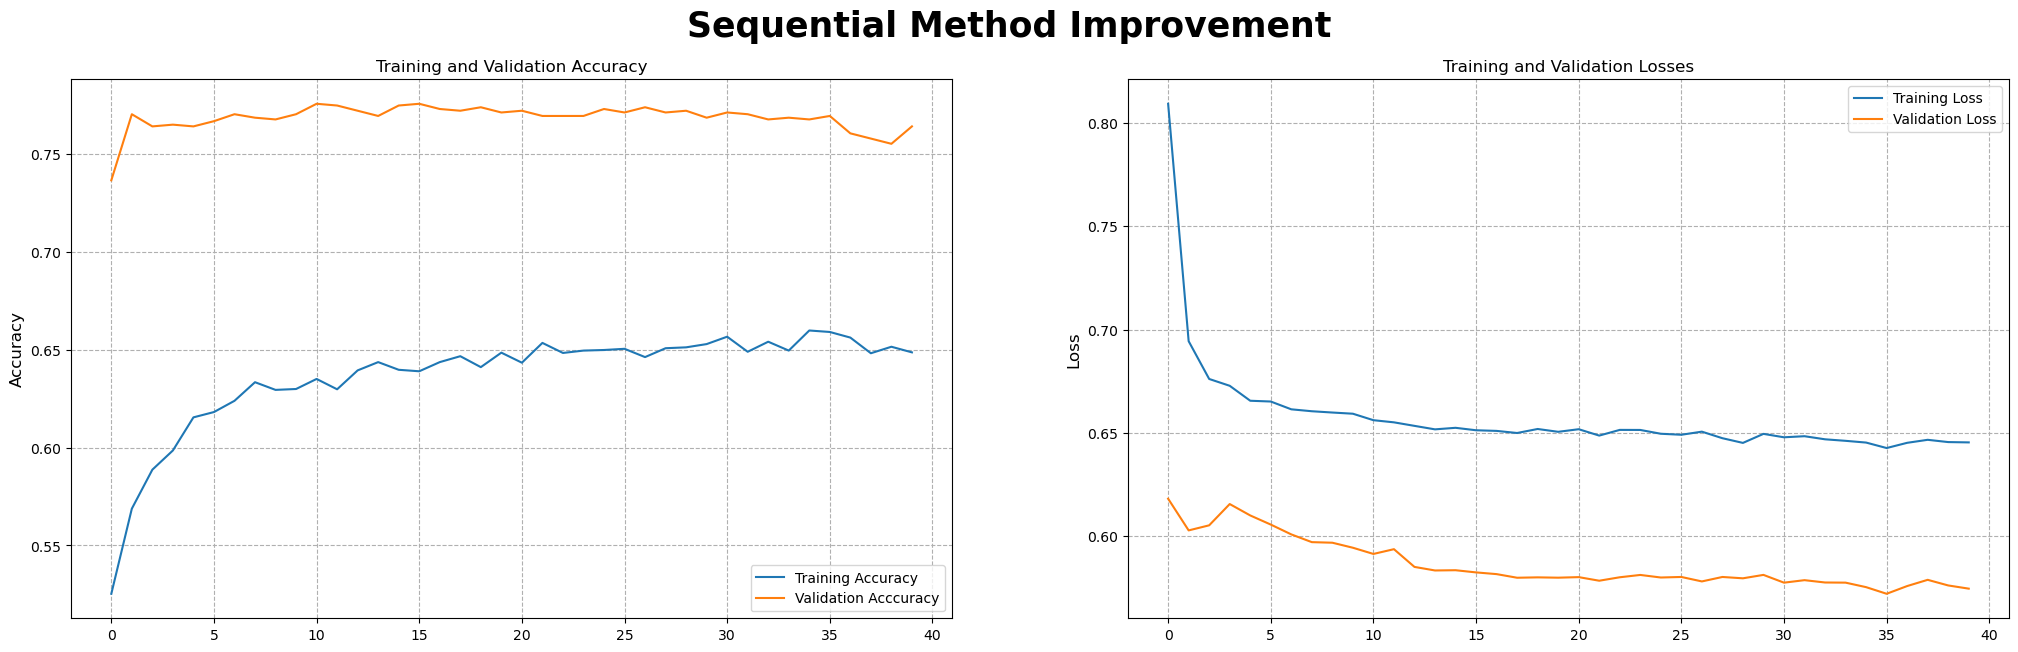

In [90]:
fig, ax = plt.subplots(1,2, figsize=(25,7))
fig.suptitle('Sequential Method Improvement', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_seq1.history['accuracy'],label="Training Accuracy")
plt.plot(history_seq1.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_seq1.history['loss'], label="Training Loss")
plt.plot(history_seq1.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

**Functional**

In [91]:
# Defining functional model architecture

def get_uncompiled_model():
    input_func2 = tf.keras.Input(shape=(12,), name='input_func1')
    input_func2 = tf.keras.layers.Dense(12, activation='relu')(input_func2)
    hidden_func2 = tf.keras.layers.BatchNormalization()(input_func2)
    hidden_func2 = layers = tf.keras.layers.Dropout(0.4)(hidden_func2)
    hidden_func2 = tf.keras.layers.Dense(8, activation='relu', name='hidden_layer_func')(input_func2)
    hidden_func2 = tf.keras.layers.BatchNormalization()(hidden_func2)
    hidden_func2 = layers = tf.keras.layers.Dropout(0.4)(hidden_func2)
    hidden_func2 = tf.keras.layers.Dense(4, activation='relu', name='hidden_layer_func')(input_func2)
    hidden_func2 = tf.keras.layers.BatchNormalization()(hidden_func2)
    output_func2 = tf.keras.layers.Dense(1, activation='sigmoid', name='output_func')(hidden_func2)
    model_func2 = tf.keras.Model(inputs=input_func2, outputs=output_func2)
    return model_func2

# Define Training Configuration (Optimizer, Loss, Metrics)
def get_compiled_model():
    model_func2 = get_uncompiled_model()
    model_func2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'],)
    return model_func2

In [92]:
# Training Functional model
model_func2 = get_compiled_model()
history_func2 = model_func2.fit(train_pipe, epochs=40, validation_data=(val_pipe))
print("\nEvaluate on test data")
result_func2 = model_func2.evaluate(test_pipe)
print('Test - Loss     : ', result_func2[0])
print('Test - Accuracy : ', result_func2[1])
print('')

Epoch 1/40
221/221 [==============================] - 2s 4ms/step - loss: 0.8700 - accuracy: 0.4816 - val_loss: 0.7148 - val_accuracy: 0.5320
Epoch 2/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.5931 - val_loss: 0.5866 - val_accuracy: 0.7180
Epoch 3/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6609 - accuracy: 0.6398 - val_loss: 0.5739 - val_accuracy: 0.7242
Epoch 4/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6540 - accuracy: 0.6422 - val_loss: 0.5609 - val_accuracy: 0.7331
Epoch 5/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6504 - accuracy: 0.6458 - val_loss: 0.5590 - val_accuracy: 0.7269
Epoch 6/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6497 - accuracy: 0.6516 - val_loss: 0.5598 - val_accuracy: 0.7304
Epoch 7/40
221/221 [==============================] - 1s 3ms/step - loss: 0.6477 - accuracy: 0.6464 - val_loss: 0.5624 - val_accuracy: 0.7313
Epoch 

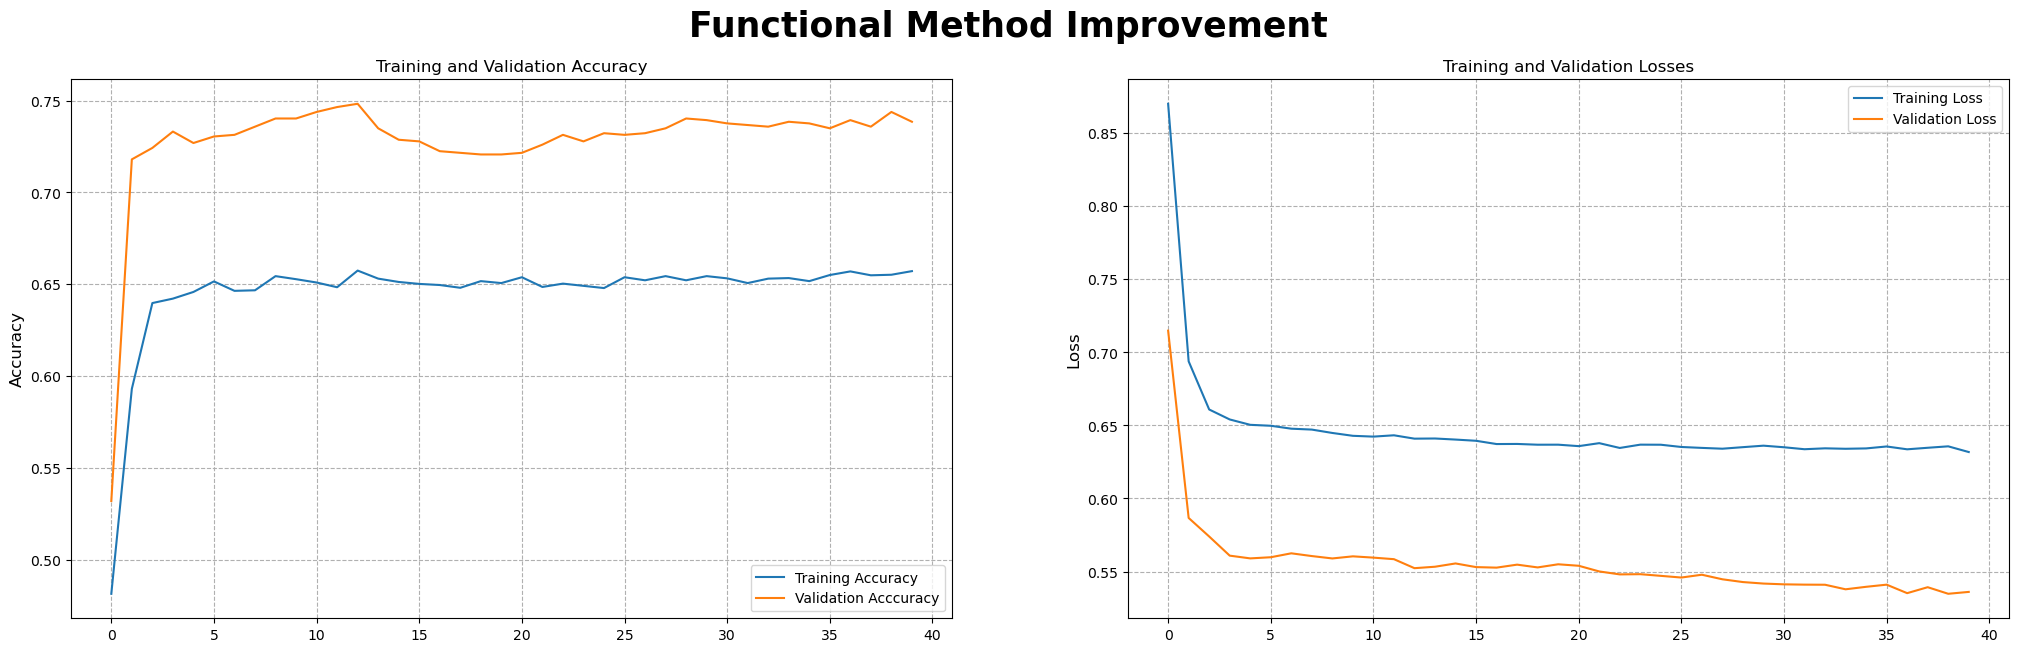

In [93]:
fig, ax = plt.subplots(1, 2, figsize = (25, 7))
fig.suptitle('Functional Method Improvement', fontsize = 25, weight = 'bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize = 12)
plt.plot(history_func2.history['accuracy'], label = "Training Accuracy")
plt.plot(history_func2.history['val_accuracy'], label = "Validation Acccuracy")
plt.ylabel("Accuracy", fontsize = 12)
plt.legend()
plt.grid(linestyle = '--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize = 12)
plt.plot(history_func2.history['loss'], label = "Training Loss")
plt.plot(history_func2.history['val_loss'], label = "Validation Loss")
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.grid(linestyle = '--')

plt.style.use('default')
plt.show()

On the model improvement, I have tried to change multiple values within the model in both sequential and functional improvement whether it's adding the hidden layers, changing the neurons, activation, and optimizer. Though the best model seems to be the Functional method with its parameters at 0.54 loss and 0.73 accuracy.

## Model Evaluation

**Sequential**

47/47 [==============================] - 0s 2ms/step
========== TEST ==========
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1024
           1       0.53      0.76      0.63       381

    accuracy                           0.75      1405
   macro avg       0.71      0.75      0.72      1405
weighted avg       0.80      0.75      0.77      1405



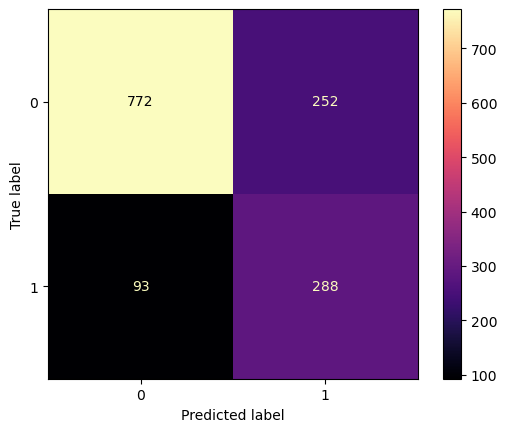

In [94]:
# predict probabilities
y_pred_seq = model_seq1.predict(test_pipe)
y_pred_seq = (y_pred_seq > 0.5)

# classification report
print("="*10,"TEST","="*10)
print(classification_report(y_test_fin, y_pred_seq, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test_fin, y_pred_seq)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.show()

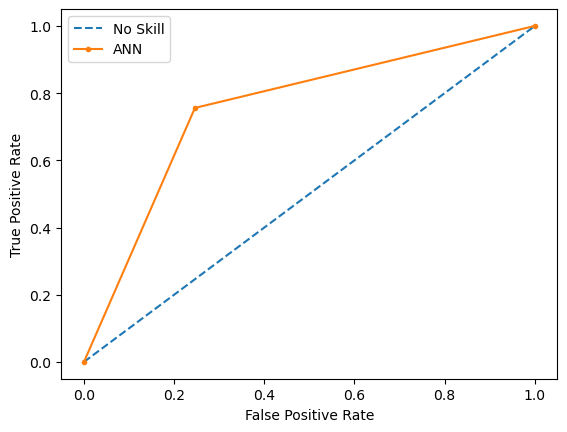

AUC score: 0.7549058809055118


In [95]:
# calculate roc curves & auc
fpr, tpr, thresholds = roc_curve(y_test_fin, y_pred_seq)
auc = roc_auc_score(y_test_fin, y_pred_seq)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(f'AUC score: {auc}')

**Functional**

47/47 [==============================] - 0s 2ms/step
========== TEST ==========
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1024
           1       0.51      0.80      0.62       381

    accuracy                           0.73      1405
   macro avg       0.71      0.75      0.71      1405
weighted avg       0.80      0.73      0.75      1405



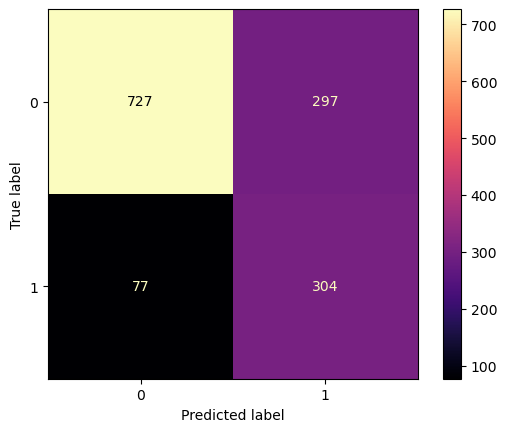

In [96]:
# predict probabilities
y_pred_func = model_func2.predict(test_pipe)
y_pred_func = (y_pred_func > 0.5)

# classification report
print("="*10,"TEST","="*10)
print(classification_report(y_test_fin, y_pred_func, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test_fin, y_pred_func)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.show()

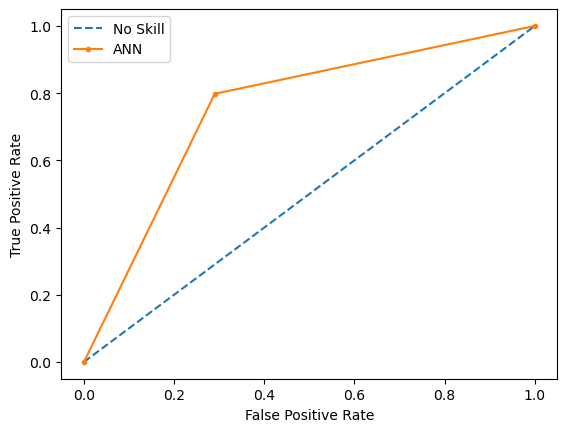

AUC score: 0.7539305999835958


In [97]:
# calculate roc curves & auc
fpr, tpr, thresholds = roc_curve(y_test_fin, y_pred_func)
auc = roc_auc_score(y_test_fin, y_pred_func)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(f'AUC score: {auc}')

## Model Saving

In [98]:
model_seq1.save('churn_seq_model.h5')
model_func2.save('churn_func_model.h5')


In [99]:
pickle.dump(scaler,open('scaler.pkl','wb'))
pickle.dump(ord_enc,open('ord_enc.pkl','wb'))

## Model Inference

In [100]:
df_inf

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,Yes,22,Fiber optic,No,No,Month-to-month,Yes,Electronic check,88.75,1885.15,No
1,0,No,No,32,DSL,No,No,One year,Yes,Bank transfer (automatic),64.85,2010.95,No
2,0,Yes,Yes,15,DSL,No,No,Month-to-month,No,Electronic check,46.30,639.45,No
3,0,No,No,7,Fiber optic,No,No,Month-to-month,No,Electronic check,96.20,639.70,No
4,0,No,No,49,Fiber optic,No,Yes,Two year,No,Credit card (automatic),100.65,4917.75,No
5,0,Yes,No,33,DSL,Yes,Yes,Two year,Yes,Mailed check,61.05,2018.40,No
6,0,Yes,Yes,14,Fiber optic,No,No,Month-to-month,Yes,Bank transfer (automatic),80.90,1152.80,No
7,0,Yes,Yes,72,No,No internet service,No internet service,Two year,No,Credit card (automatic),19.40,1363.25,No
8,0,No,No,1,Fiber optic,No,No,Month-to-month,Yes,Electronic check,70.30,70.30,Yes
9,1,No,No,37,Fiber optic,No,No,Month-to-month,Yes,Electronic check,101.10,3744.05,Yes


In [101]:
num_col = df_inf[['tenure', 'MonthlyCharges', 'TotalCharges']]
cat_col = df_inf[['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']]

In [102]:
num_inf = scaler.transform(num_col)
cat_inf = ord_enc.transform(cat_col)

In [103]:
x_inf = np.concatenate([num_inf, cat_inf,df_inf[['SeniorCitizen']]], axis=1).astype("float32")

In [104]:
np.round(model_func2.predict(x_inf).reshape(-1))

1/1 [==============================] - 0s 115ms/step


array([1., 0., 0., 1., 0., 0., 1., 0., 1., 1.], dtype=float32)

## Conclusion

The model evaluation seems to support the findings on the model improvement for the most part since there are 727 people correctly predicted as 0 and 304 people correctly predicted as 1 which is better compared to the sequential model that only successfully predicted 772 people at 0 and 288 people correctly predicted as 1. Though after looking at the inference and comparing it with the inference data, it seems that the model got 3 people who got wrongly predicted as "Yes". Therefore, this model could be further improved by fiddling around with the model parameters and comparing the sequential model to the functional model since the result is pretty good, but not good enough to actually be used in real life.